# 景区评论情感分析
1. 数据预处理
2. 文本去重,jieba分词
3. 用户情感倾向分析 绘图 柱状图 饼图
4. 使用Vectorizer向量化文本并绘制词云图
5. 使用word2vec技术向量化文本+词嵌入技术+双向LSTM构建循环神经网络 训练多分类单标签的神经网络模型 并对文本情感进行预测

In [1]:
#导入数据分析的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#不使用plt.show()也可以直接展示图片
%matplotlib inline  
#设置绘图显示中文 负号
plt.rcParams['font.sans-serif']=['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号

#导入分词 词云库
import jieba                       #中文分词
from wordcloud import WordCloud    #绘制词云图
from imageio import imread         #将图片转换为数组
import random

#导入文本向量化库 和正则库
import re


In [2]:
train_data=pd.read_csv('scenic_train.csv')
train_data.head(10)

景区名称          昵称   评分        评论时间  点赞数  \
0  黄果树瀑布         周翅膀  4.0  2013-02-27    0   
1  黄果树瀑布    ma****fu  4.0  2021-03-29    0   
2  黄果树瀑布  dlee_china  5.0  2021-03-27    0   
3  黄果树瀑布      Purple  3.0  2021-03-28    1   
4  黄果树瀑布         芦惠忠  5.0  2021-03-28    0   
5  黄果树瀑布         码头1  5.0  2021-03-29    0   
6  黄果树瀑布     ~花~骨~朵~  0.0  2021-03-29    0   
7  黄果树瀑布      影子先生LJ  4.0  2021-03-29    0   
8  黄果树瀑布    yb****88  5.0  2021-03-29    0   
9  黄果树瀑布  M32****811  5.0  2021-03-29    0   

                                                评论文本  
0  不要以为我去看了黄果树，我只是在门口路过。。。又是遇到高速分流，说是前面有个200多顿的变压...  
1       景色不错，可惜出口商业化太严重！出了出口，左绕右绕，全是卖东西的，绕了半小时才到乘车点！  
2                                              性价比高，  
3                 淡季去太坑，220的票，水帘洞都没开放，景区里也是到处施工，体验太差  
4                                         非常，非常，非常OK  
5                                 壮观啊，气势磅礴，景色不错，气候宜人  
6  “白水絮棉不用弓弹花自散，虹霞似锦何须梭织天生成”，此乃是黄果树瀑布的真实写照。&#x0A;...  
7                                           一般化，不值得。  
8    线路设计很成熟，有大电梯，没走多少冤枉路，景色也不错😊总体超赞，景色不错，有趣好玩，性价比高，  
9            谭导确实不错，非常负责，讲解不错，黄果树一日游，无购物，纯玩！感谢！性价比高，

## 1. 文本分析

### 1.1 EDA探索性数据分析与绘制图表
1. 对文本进行jieba分词 并使用哈工大停用词表 去除文本中的停用词

2. 给景区评论打上标签 消极 中立 积极 根据评分

3. 绘制景区评分频数图

4. 绘制景区情感占比图 



In [3]:
#原始数据有27706行 6列
train_data.shape

(27706, 6)

In [4]:
#可以看到五个景区 我们需要分别对这五个小区进行分析
train_data['景区名称'].value_counts()

黄果树瀑布      6697
西江千户苗寨     6218
荔波小七孔景区    5510
梵净山        5148
织金洞        4133
Name: 景区名称, dtype: int64

In [5]:
#这是我们进行分析需要的列 去除了评论时间 昵称 点赞数 对我们来说不是很有帮助的数据
data=train_data[['景区名称','评分','评论文本']]
data.head()

景区名称   评分                                               评论文本
0  黄果树瀑布  4.0  不要以为我去看了黄果树，我只是在门口路过。。。又是遇到高速分流，说是前面有个200多顿的变压...
1  黄果树瀑布  4.0       景色不错，可惜出口商业化太严重！出了出口，左绕右绕，全是卖东西的，绕了半小时才到乘车点！
2  黄果树瀑布  5.0                                              性价比高，
3  黄果树瀑布  3.0                 淡季去太坑，220的票，水帘洞都没开放，景区里也是到处施工，体验太差
4  黄果树瀑布  5.0                                         非常，非常，非常OK

### 1.1.1 对评论文本进行中文分词

In [6]:
#定义一个将中文进行分词的函数 并返回分好词的数据
def text_processing(all_data):
    stopWord_path='./source/hit_stopwords.txt'
    #加载停用词 停用词要是列表形式才能使用
    stopWord=[]
    with open( stopWord_path,'r',encoding='utf-8') as fr:
        for word in fr.readlines():
            stopWord.append(word.strip())
    #stopWord 为列表形式的停用词

    #h函数中嵌套一个分词函数
    def cut_word(sent):
        sent=sent.replace('&#','')
        sent=sent.replace('.&#','')
        line=re.sub(r'[a-zA-Z0-9]*','',sent) #sub实现字符串替换处理 将26个英文字母大小写和数字0-9替换为空白
        wordList=jieba.lcut(line) #精确模式
        #返回一个用空格连接的字符串 且里面的文本去除了停用词
        return ' '.join([word for word in wordList if word not in stopWord and len(word)>1])
    #对all_data中的所有评论文本进行分词 apply自动遍历对每行进行cut_word 返回一个series对象
    all_data['word_list']=all_data['评论文本'].apply(cut_word)

    #返回已经分好词的函数
    return all_data
    

In [7]:
#经过中文分词后的数据 分词处理时间 1min左右
data2 = text_processing(data)
data2.head(10)


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Allen\AppData\Local\Temp\jieba.cache
Loading model cost 0.962 seconds.
Prefix dict has been built successfully.


景区名称   评分                                               评论文本  \
0  黄果树瀑布  4.0  不要以为我去看了黄果树，我只是在门口路过。。。又是遇到高速分流，说是前面有个200多顿的变压...   
1  黄果树瀑布  4.0       景色不错，可惜出口商业化太严重！出了出口，左绕右绕，全是卖东西的，绕了半小时才到乘车点！   
2  黄果树瀑布  5.0                                              性价比高，   
3  黄果树瀑布  3.0                 淡季去太坑，220的票，水帘洞都没开放，景区里也是到处施工，体验太差   
4  黄果树瀑布  5.0                                         非常，非常，非常OK   
5  黄果树瀑布  5.0                                 壮观啊，气势磅礴，景色不错，气候宜人   
6  黄果树瀑布  0.0  “白水絮棉不用弓弹花自散，虹霞似锦何须梭织天生成”，此乃是黄果树瀑布的真实写照。&#x0A;...   
7  黄果树瀑布  4.0                                           一般化，不值得。   
8  黄果树瀑布  5.0    线路设计很成熟，有大电梯，没走多少冤枉路，景色也不错😊总体超赞，景色不错，有趣好玩，性价比高，   
9  黄果树瀑布  5.0            谭导确实不错，非常负责，讲解不错，黄果树一日游，无购物，纯玩！感谢！性价比高，   

                                           word_list  
0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...  
1          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车  
2                                                性价比  
3                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验  
4                                           非常 非常 非常  
5                                 壮观 气势磅礴 景色 不错 气候宜人  
6  白水 絮棉 不用 弓弹 自散 虹霞 似锦 何须 梭织 生成 乃是 黄果树 瀑布 真实写照 景...  
7                                             一般化 值得  
8     线路 设计 成熟 有大 电梯 冤枉路 景色 不错 总体 超赞 景色 不错 有趣 好玩 性价比  
9          谭导 确实 不错 非常 负责 讲解 不错 黄果树 一日游 购物 纯玩 感谢 性价比

In [8]:
# 去除掉原来的为分词的文本
data3 = data2.drop("评论文本",axis=1)
data3.head()

景区名称   评分                                          word_list
0  黄果树瀑布  4.0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...
1  黄果树瀑布  4.0          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车
2  黄果树瀑布  5.0                                                性价比
3  黄果树瀑布  3.0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验
4  黄果树瀑布  5.0                                           非常 非常 非常

### 1.1.2 使用snowNLP进行情绪判断 给文本打上情感标签
1. 越接近1表示正面情绪 越接近0表示负面情绪
2. 定义函数 get_sentiment_cn 判断文本的属于积极情绪的概率
3. 概率在0-0.3 设定为消极情绪 0.3-0.7设定为中立情绪 0.7-1设定为积极情绪
4. 定义函数add_labels 给0-0.3的标为情绪0 0.3-0.7标为情绪1 0.7-1标为情绪2


In [9]:
#导入snowNLP库 
from snownlp import SnowNLP

# 得到文本情感被评为正向的概率
def get_sentiment_cn(text):
    try:
        s=SnowNLP(text)
        return s.sentiments
    #异常的数据会返回-1
    except:
        return -1
#0为消极 1为中立 2为积极
def add_emotion(score):
    if score>=0 and score<=0.3:
        return 0
    elif score>0.3 and score<0.7:
        return 1
    else:
        return 2

data3['score']=data3['word_list'].apply(get_sentiment_cn)
data3.head()
#时间花费大概:3min

景区名称   评分                                          word_list     score
0  黄果树瀑布  4.0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...  0.399158
1  黄果树瀑布  4.0          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车  0.908740
2  黄果树瀑布  5.0                                                性价比  0.920762
3  黄果树瀑布  3.0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验  0.028886
4  黄果树瀑布  5.0                                           非常 非常 非常  0.526233

###### 去除正向情感概率异常数据

In [10]:
#查看score==-1的数据  及异常数据 有67条异常的数据 
print("======删除异常数据前=========")
print(data3.shape)
start = data3.shape[0]
print(data3[data3['score']==-1].count())
drop_index=data3[data3['score']==-1].index
#删除score==-1的数据 这是异常的数据
data4=data3.drop(index=drop_index)

print("======删除异常数据后=========")

#输出删除异常数据后的情况 行数少了162行 异常数据已清除
print(data4.shape)
print(data4[data4['score']==-1].count())

end = data4.shape[0]
print("删除的异常数据数:{}".format(start-end))

======删除异常数据前=========
(27706, 4)
景区名称         162
评分           162
word_list    162
score        162
dtype: int64
======删除异常数据后=========
(27544, 4)
景区名称         0
评分           0
word_list    0
score        0
dtype: int64
删除的异常数据数:162


##### 给文本打上情感标签

In [11]:
#给每条评论打上情绪 标签
#正向情感评分在0-0.3 设定为消极情绪 0.3-0.7设定为中立情绪 0.7-1设定为积极情绪
data4['emotion']=data4['score'].apply(add_emotion)
#0为消极 1为中立 2为积极
data4.head()

景区名称   评分                                          word_list     score  \
0  黄果树瀑布  4.0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...  0.399158   
1  黄果树瀑布  4.0          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车  0.908740   
2  黄果树瀑布  5.0                                                性价比  0.920762   
3  黄果树瀑布  3.0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验  0.028886   
4  黄果树瀑布  5.0                                           非常 非常 非常  0.526233   

   emotion  
0        1  
1        2  
2        2  
3        0  
4        1

### 1.1.3 定义一个数据分析的类text_analyse 其中定义了以下几个函数

当然 对输入的数据有要求 我们将原始数据提取一下 需要的数据是上面的data4数据集

1. plot_bar(self,all_data) 绘制评分频数柱状图
2. plot_pie(self,all_data) 绘制情感占比饼图
3. plot_hist(self,all_data) 绘制snowNLP 情感评为正向的得分 直方图
4. plot_huan(self,all_data) 绘制情感占比环形图
3. word_cloud(self,cut_text) 对分词后的文本进行基于文本的词云图的绘制

In [12]:
#self 是实例本身 相当于一个实例化的对象
class text_analyse(object):
    def __init__(self):
        pass
    
    #定义一个绘制各个景区评分频数柱状图的函数
    def plot_bar(self,all_data):
        
        # 绘制总的评分柱状图
        need_data=all_data
        score=need_data['评分'].value_counts().sort_index()
        score=score.reset_index()
        score.columns=['评分','频数']

        x=list(score['评分'])
        y=list(score['频数'])
        plt.figure(figsize=(10,5))
        plt.xlabel("评分")
        plt.ylabel("频数")
        plt.title("景区总评分柱状图")
        plt.bar(x,y)
        for a,b in zip(x,y):   #柱子上的数字显示
            plt.text(a,b,'%d'%b,ha='center',va='bottom',fontsize=14)
        plt.savefig("./results/bar_pictures/all_scenic_bar.jpg")
        plt.show()
        
        # 绘制每个景区的评分柱状图
        #提取出每个景区的数据 一共五个景区
        scenic_name=["黄果树瀑布","西江千户苗寨","荔波小七孔景区","梵净山","织金洞"]
        for name in scenic_name:
            need_data = all_data[all_data['景区名称']==name]
            
            #得到按评分由小到大的频数 索引为评分 得到景区的评分种类和各种类的数目
            score=need_data['评分'].value_counts().sort_index()
            
            # 将索引变为列 index 评分 两列 转成一个DataFrame对象 
            #此步是为找出评分与频数方便后面绘制柱状图 即找出柱状图的横坐标和纵坐标
            score=score.reset_index()
            
            #重命名列
            score.columns=['评分','频数']

            x=list(score['评分'])
            y=list(score['频数'])
            plt.figure(figsize=(10,5))
            plt.xlabel("评分")
            plt.ylabel("频数")
            plt.title("{}评分柱状图".format(name))
            plt.bar(x,y)
            for a,b in zip(x,y):   #柱子上的数字显示
                plt.text(a,b,'%d'%b,ha='center',va='bottom',fontsize=14)
            plt.savefig("./results/bar_pictures/{}_bar.jpg".format(name))
            plt.show()
    
        
        
        
        
        #定义一个绘制三种情感占比的饼状图
    def plot_pie(self,all_data):
        # 绘制景区所有评论总的情感情感占比饼图
        need_data = all_data
        nums1=need_data['emotion'].value_counts().sort_index()
        nums1=nums1.reset_index()
        nums1.columns=['情感','频数']
        x=list(nums1['频数'])
        plt.figure(figsize=(10,5))
        colors=['red','cyan','green']
        plt.pie(x=x,labels=['消极','中立','积极'],colors=colors,shadow=1,autopct='%.1f%%',explode=[0,0.05,0.05])
        plt.title("所有景区评论的情感占比")
        plt.savefig("./results/pie_pictures/all_scenic_pie.jpg")
        plt.show()

        
        
        #分别绘制五个景区的评论情感占比饼图
        scenic_name=["黄果树瀑布","西江千户苗寨","荔波小七孔景区","梵净山","织金洞"]
        for name in scenic_name:
            need_data = all_data[all_data['景区名称']==name]

            #sort_index后按索引(情感0-2)升序排列 0， 1，2分别对应消极 中立 积极
            
            nums1=need_data['emotion'].value_counts().sort_index()
            nums1=nums1.reset_index()
            nums1.columns=['情感','频数']
            x=list(nums1['频数'])
            plt.figure(figsize=(10,5))
            colors=['red','cyan','green']
            plt.pie(x=x,labels=['消极','中立','积极'],colors=colors,shadow=1,autopct='%.1f%%',explode=[0,0.05,0.05])
            plt.title("{}的各情感占比".format(name))
            plt.savefig("./results/pie_pictures/{}_pie.jpg".format(name))
            plt.show()
        
        
    # 绘制直方图
    def plot_hist(self,all_data):
        
        # 绘制总的snowNLP得分直方图
        need_data = all_data
        plt.figure(figsize=(10,5))
        plt.hist(need_data.score,color='forestgreen')
        plt.title('总评论文本snowNLP评分直方图')
        plt.ylabel("评论条数")
        plt.xlabel("情感为正向的概率")
        plt.savefig("./results/hist_pictures/all_scenic_NLPscore_hist.png")
        plt.show()
        
        
        #绘制五个景区的被snowNLP评为正向情感得分(概率)的直方图
        scenic_name=["黄果树瀑布","西江千户苗寨","荔波小七孔景区","梵净山","织金洞"]
        for name in scenic_name:
            need_data = all_data[all_data['景区名称']==name]
            plt.figure(figsize=(10,5))
            plt.hist(need_data.score,color='forestgreen')
            plt.title('{}评论文本snowNLP评分直方图'.format(name))
            plt.ylabel("评论条数")
            plt.xlabel("情感为正向的概率")
            plt.savefig("./results/hist_pictures/{}_NLPscore_hist.png".format(name))
            plt.show()
            

    # 绘制环形图
    def plot_huan(self,all_data):
        # 绘制总的情感环形图
        need_data = all_data
        huan_data=need_data['emotion'].value_counts()
        huan_data=pd.DataFrame(huan_data)
        
        #按索引排序 索引为情感标签 0 1 2
        hx_data=huan_data.sort_index()
        
        label_list=['消极','中立','积极']

        # 绘制情感占比环形图
        plt.figure(figsize=(10,5))
        plt.pie(hx_data.emotion,radius=1,wedgeprops=dict(width=0.5,edgecolor='w'),labels=label_list)
        plt.title("总评论文本情感环形图")
        plt.savefig("./results/huan_pictures/all_scenic_huanxin_pic.png")
        plt.show()
        
        # 分别绘制五个景区的情感环形图
        
        scenic_name=["黄果树瀑布","西江千户苗寨","荔波小七孔景区","梵净山","织金洞"]
        for name in scenic_name:
            need_data = all_data[all_data['景区名称']==name]
            huan_data=need_data['emotion'].value_counts()
            huan_data=pd.DataFrame(huan_data)

            #按索引排序 索引为情感标签 0 1 2
            hx_data=huan_data.sort_index()
          
            label_list=['消极','中立','积极']

            # 绘制情感占比环形图
            plt.figure(figsize=(5,5))
            plt.pie(hx_data.emotion,radius=1,wedgeprops=dict(width=0.5,edgecolor='w'),labels=label_list)
            plt.title("{}评论文本情感环形图".format(name))
            plt.savefig("./results/huan_pictures/{}_huanxin_pic.png".format(name))
            plt.show()
        
        
                   

    #定义一个绘制基于文本的词云图的函数
    #传入的数据为每个景区的分词后的文本数据 
    def word_cloud(self,cut_text,strn='d',flag='所有情感'):
        font='./source/simhei.ttf' #指定能显示中文的字体
        i=random.randint(0,3)
        #背景库
        pictures=['./source/waiter1.png','./source/waiter2.png','./source/tree1.png','./source/tree2.png']
        pic=pictures[i] #指定词云图的背景
        #指定mask参数时需要将图片转换为数组的形式 imread将图片转换为数组形式
        b_mask=imread(pic)
        wc=WordCloud(
            font_path=font,
            background_color='white',
            mask=b_mask #设置背景图片
        )
        wc.generate(cut_text)
        plt.figure(figsize=(16,8))
        plt.imshow(wc)
        #取消坐标轴
        plt.axis('off') 
        plt.show()
        #保存
        if flag=="所有情感":
            wc.to_file("./results/all_word_cloud_pictures/{}_word_clod.jpg".format(strn))
        elif flag=="消极情感":
            wc.to_file("./results/negative_word_cloud/{}_negative_word_clod.jpg".format(strn))
            
        
        
        
    
    

In [13]:
print(data4.shape)
data4.head()

(27544, 5)


景区名称   评分                                          word_list     score  \
0  黄果树瀑布  4.0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...  0.399158   
1  黄果树瀑布  4.0          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车  0.908740   
2  黄果树瀑布  5.0                                                性价比  0.920762   
3  黄果树瀑布  3.0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验  0.028886   
4  黄果树瀑布  5.0                                           非常 非常 非常  0.526233   

   emotion  
0        1  
1        2  
2        2  
3        0  
4        1

In [14]:
#实例化文本分析类
mytextp=text_analyse()


#### 1.1.4 绘制评分频数柱状图

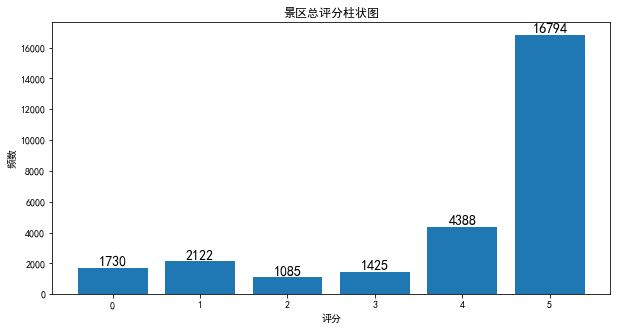

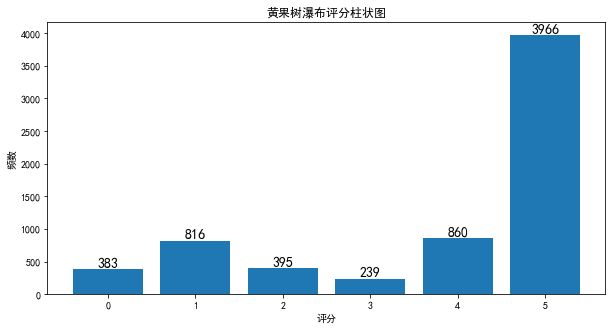

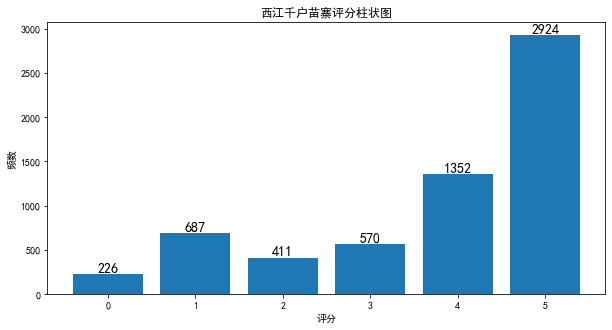

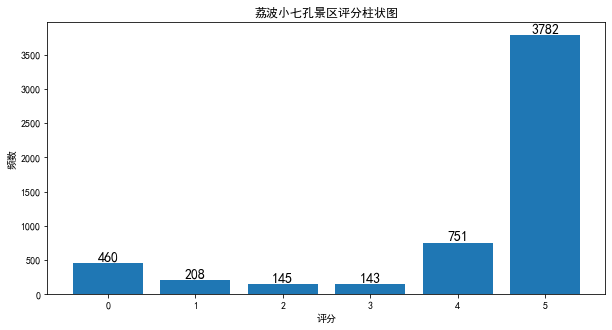

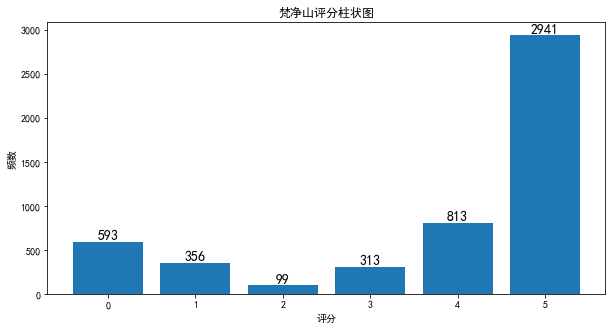

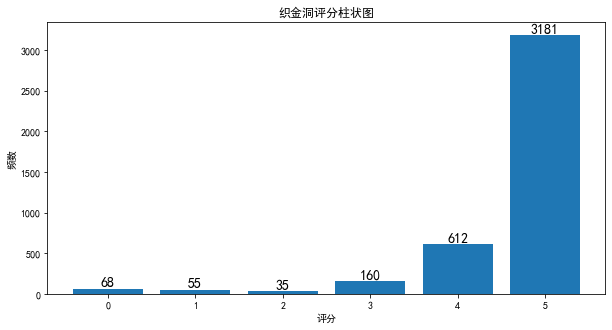

In [15]:
# 绘制客户评分柱状图
mytextp.plot_bar(data4)

#### 1.1.5 绘制情感占比饼图

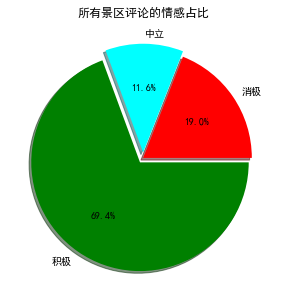

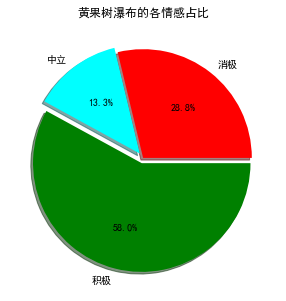

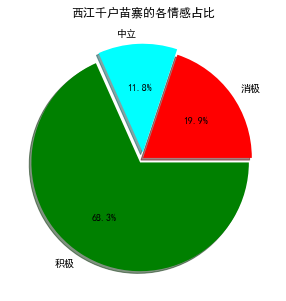

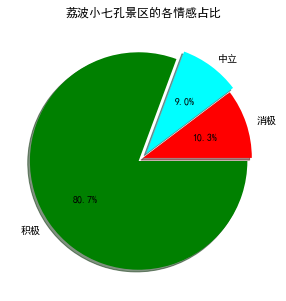

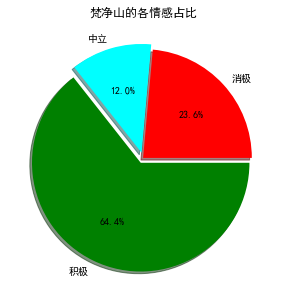

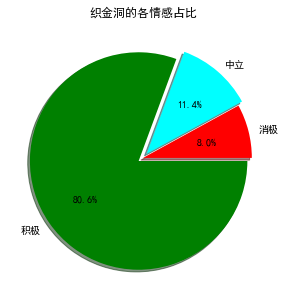

In [16]:
# 绘制情感占比饼图
mytextp.plot_pie(data4)


#### 1.1.6 绘制snowNLP评论正向概率直方图

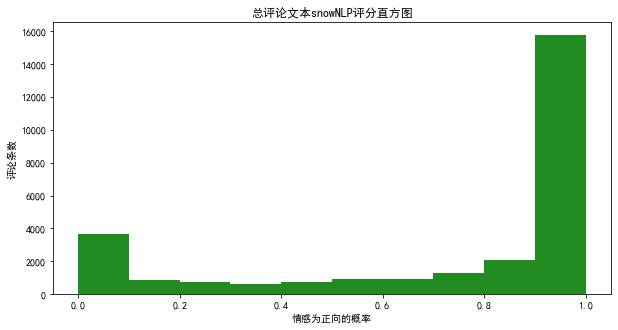

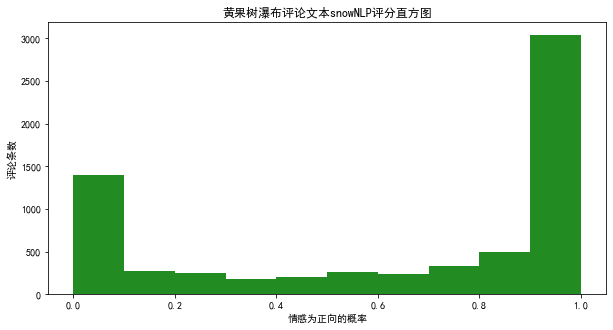

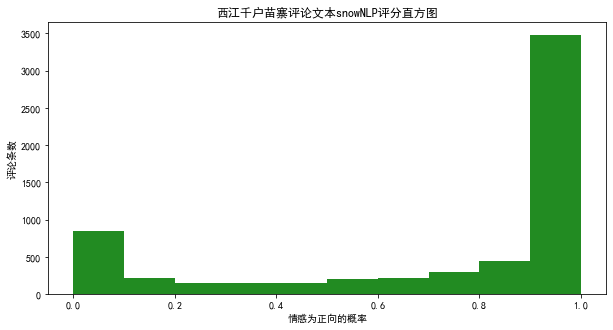

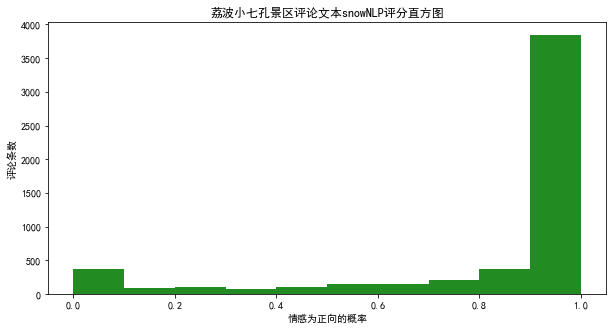

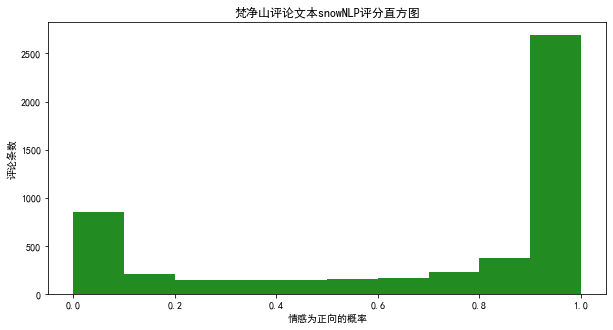

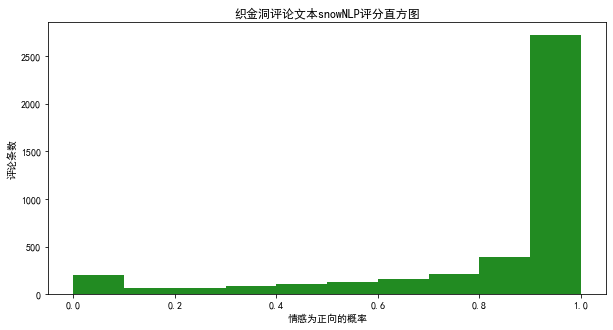

In [17]:
# 绘制snowNLP评论正向概率直方图
mytextp.plot_hist(data4)

#### 1.1.7 绘制情感占比环形图

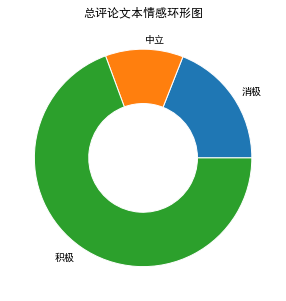

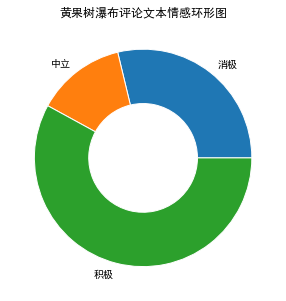

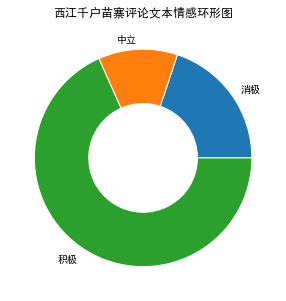

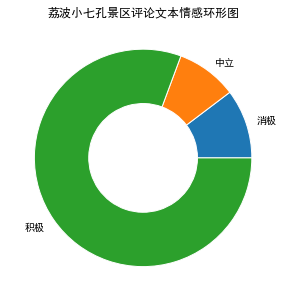

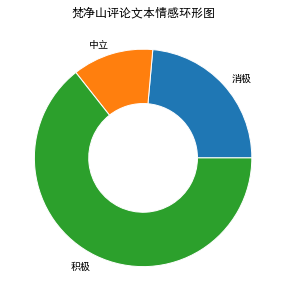

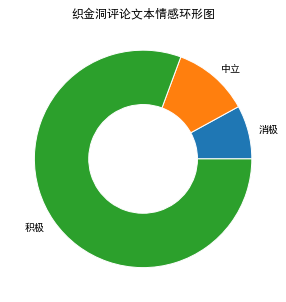

In [18]:
# 绘制情感占比环形图
mytextp.plot_huan(data4)

## 1.2 绘制基于文本的词云图
1. 绘制总数据的情感词云图
2. 分别绘制各个景区的情感词云图
3. 绘制总数据的消极情感词云图
4. 分别绘制各个景区的消极情感词云图

#### 1.2.1 绘制总数居的情感词云图

In [19]:
data4.head()

景区名称   评分                                          word_list     score  \
0  黄果树瀑布  4.0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...  0.399158   
1  黄果树瀑布  4.0          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车  0.908740   
2  黄果树瀑布  5.0                                                性价比  0.920762   
3  黄果树瀑布  3.0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验  0.028886   
4  黄果树瀑布  5.0                                           非常 非常 非常  0.526233   

   emotion  
0        1  
1        2  
2        2  
3        0  
4        1

总景区数据长度为27544 ,分词文本转换成字符串的长度为1930813


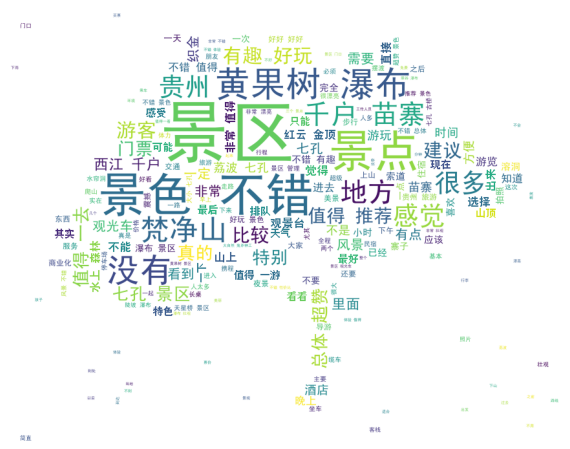

In [20]:
mytexta = text_analyse() 

#分好词后的数据及其情感标签
scenic_data = data4[['word_list','emotion']]
#要将分好词的文本转换成字符串 才能放到定义的词云函数中去 绘制词云图
scenic_data_text=' '.join(list(scenic_data['word_list']))
print("{}景区数据长度为{} ,分词文本转换成字符串的长度为{}".format("总",scenic_data.shape[0],len(scenic_data_text)))

mytexta.word_cloud(scenic_data_text,"所有","所有情感")

##### 1.2.2 绘制各个景区情感词云图

黄果树瀑布景区数据长度为6659 ,分词文本转换成字符串的长度为494248


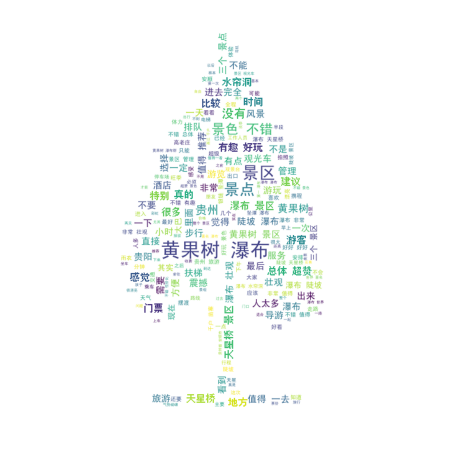

西江千户苗寨景区数据长度为6170 ,分词文本转换成字符串的长度为424722


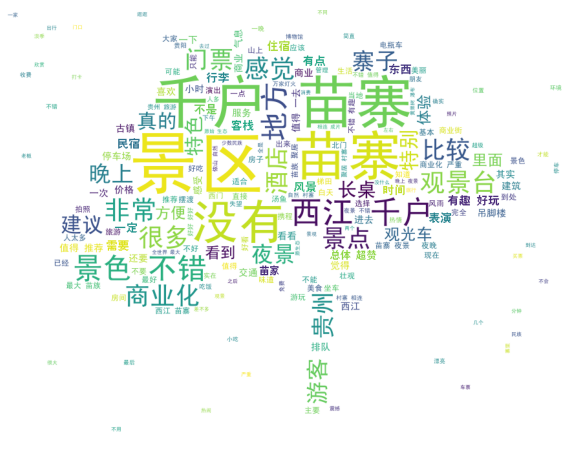

荔波小七孔景区景区数据长度为5489 ,分词文本转换成字符串的长度为429094


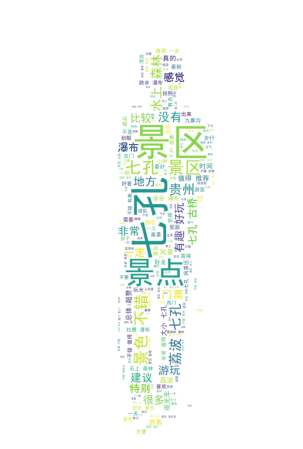

梵净山景区数据长度为5115 ,分词文本转换成字符串的长度为399462


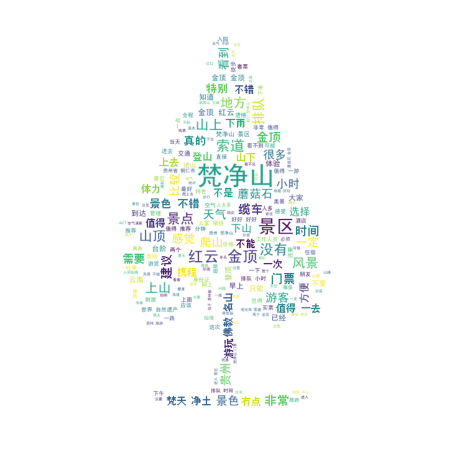

织金洞景区数据长度为4111 ,分词文本转换成字符串的长度为183283


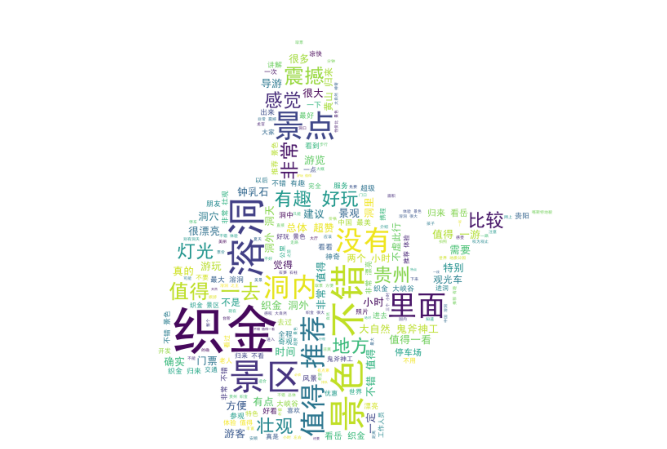

In [21]:
scenic_name=["黄果树瀑布","西江千户苗寨","荔波小七孔景区","梵净山","织金洞"]
# 实例化文本分析对象 调用其绘制词云图函数
mytexta = text_analyse() 
for name in scenic_name:
    #分好词后的数据及其情感标签
    scenic_data = data4[['word_list','emotion']][data4['景区名称']==name]
    #要将分好词的文本转换成字符串 才能放到定义的词云函数中去 绘制词云图
    scenic_data_text=' '.join(list(scenic_data['word_list']))
    print("{}景区数据长度为{} ,分词文本转换成字符串的长度为{}".format(name,scenic_data.shape[0],len(scenic_data_text)))
    
    mytexta.word_cloud(scenic_data_text,name,"所有情感")
    

#### 1.2.3 绘制总数据的消极情感词云图

In [22]:
data4.head()

景区名称   评分                                          word_list     score  \
0  黄果树瀑布  4.0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...  0.399158   
1  黄果树瀑布  4.0          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车  0.908740   
2  黄果树瀑布  5.0                                                性价比  0.920762   
3  黄果树瀑布  3.0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验  0.028886   
4  黄果树瀑布  5.0                                           非常 非常 非常  0.526233   

   emotion  
0        1  
1        2  
2        2  
3        0  
4        1

总景区消极评论数据长度为5242 ,分词文本转换成字符串的长度为449060


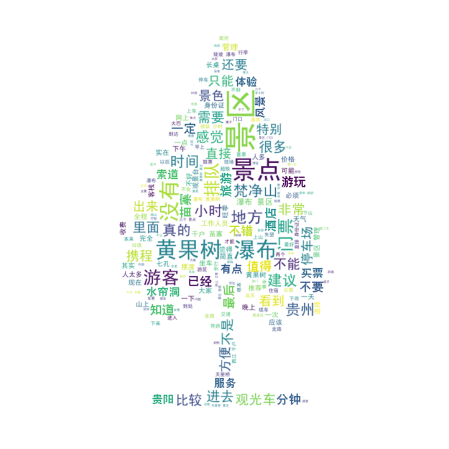

In [23]:
mytexta = text_analyse() 

#分好词后的数据及其情感标签
scenic_data = data4[['word_list','emotion']][data4['emotion']==0]
#要将分好词的文本转换成字符串 才能放到定义的词云函数中去 绘制词云图
scenic_data_text=' '.join(list(scenic_data['word_list']))
print("{}景区消极评论数据长度为{} ,分词文本转换成字符串的长度为{}".format("总",scenic_data.shape[0],len(scenic_data_text)))

mytexta.word_cloud(scenic_data_text,"所有","消极情感")

#### 1.2.4 绘制各个景区的消极情感词云图

黄果树瀑布景区消极数据长度为1915 ,分词文本转换成字符串的长度为191176


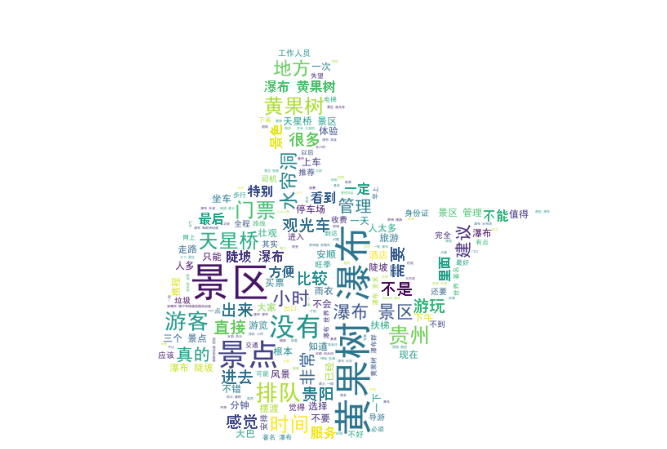

西江千户苗寨景区消极数据长度为1227 ,分词文本转换成字符串的长度为100248


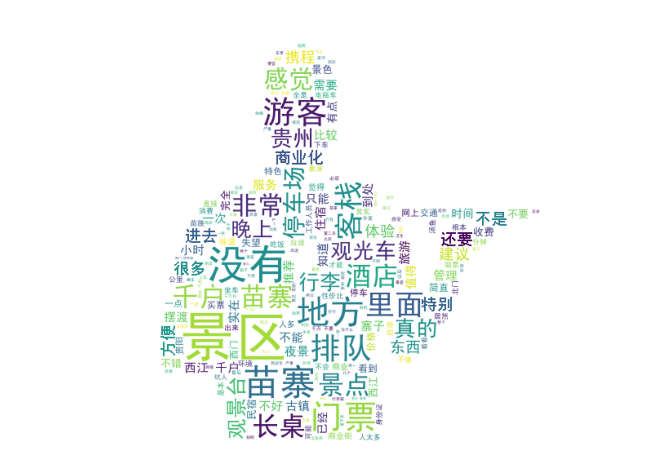

荔波小七孔景区景区消极数据长度为566 ,分词文本转换成字符串的长度为48595


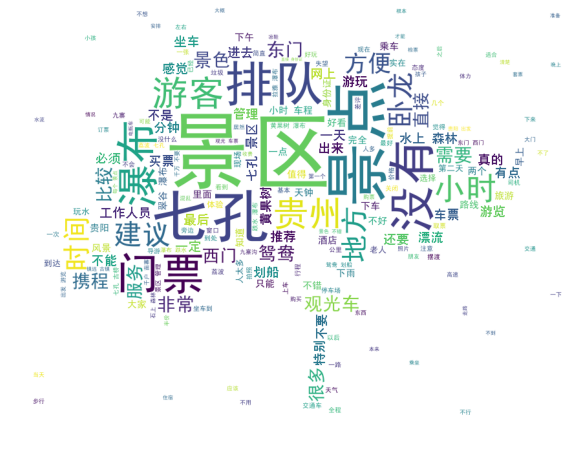

梵净山景区消极数据长度为1206 ,分词文本转换成字符串的长度为92193


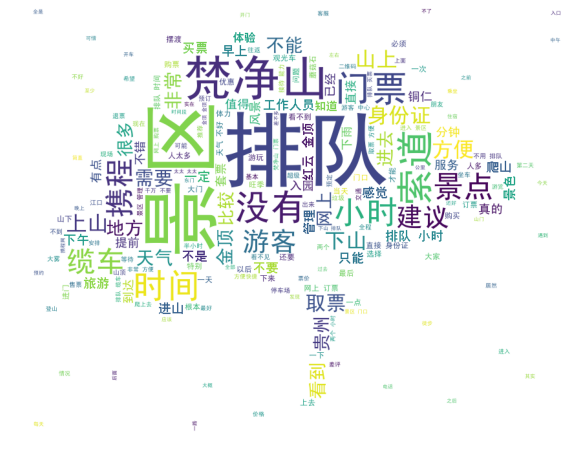

织金洞景区消极数据长度为328 ,分词文本转换成字符串的长度为16844


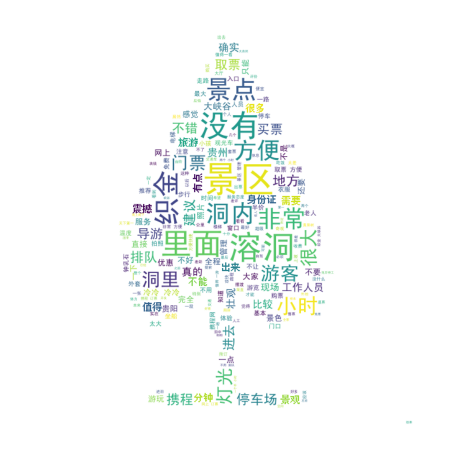

In [24]:
scenic_name=["黄果树瀑布","西江千户苗寨","荔波小七孔景区","梵净山","织金洞"]
# 实例化文本分析对象 调用其绘制词云图函数
mytexta = text_analyse() 
for name in scenic_name:
    #分好词后的数据及其情感标签
    scenic_data1 = data4[['word_list','emotion']][data4['景区名称']==name]
    scenic_data2 = scenic_data1[scenic_data1['emotion']==0]
    #要将分好词的文本转换成字符串 才能放到定义的词云函数中去 绘制词云图
    scenic_data_text=' '.join(list(scenic_data2['word_list']))
    print("{}景区消极数据长度为{} ,分词文本转换成字符串的长度为{}".format(name,scenic_data2.shape[0],len(scenic_data_text)))
    
    mytexta.word_cloud(scenic_data_text,name,"消极情感")

***

<hr />

### 1. 3.将文本向量化 绘制基于词频的词云图
1. 使用TfidfVectorizer 生成词频矩阵
2. 基于词频生成词云图 
3. 向量化后的数据

In [25]:
all_data = data4[['word_list','emotion']]
all_data.shape

(27544, 2)

In [26]:
all_data.head()

word_list  emotion
0  不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...        1
1          景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车        2
2                                                性价比        2
3                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验        0
4                                           非常 非常 非常        1

In [28]:
# 积极情感评论
positive_view = all_data[all_data['emotion']==2]
positive_view.head()


word_list  emotion
1       景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车        2
2                                             性价比        2
5                              壮观 气势磅礴 景色 不错 气候宜人        2
7                                          一般化 值得        2
8  线路 设计 成熟 有大 电梯 冤枉路 景色 不错 总体 超赞 景色 不错 有趣 好玩 性价比        2

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
#定义一个向量化文本并绘制基于词频的词云图的函数
#data上面的属性为word_list emotion的数据
def text_vect(data,n):
    #实例化词袋
    tfidf_vect=TfidfVectorizer(min_df=n) #过滤掉出现频率少于3%的词
    #fit_transform中要为series对象
    word_matrix=tfidf_vect.fit_transform(data['word_list'])
    print(word_matrix.shape)
    #词汇表 可以看到各个词出现的频数
    word_table=tfidf_vect.vocabulary_
    #词频矩阵 每一行都是数字 数字为几代表对应的单词在这行文本中出现几次
    datas=word_matrix.toarray()
    labels=data['emotion']
    
    #生成基于词频的词云图
    font='./source/simhei.ttf'
    pictures=['./source/waiter1.png','./source/waiter2.png','./source/tree1.png','./source/tree2.png']
    i=random.randint(0,3)
    pic=pictures[i] #指定词云图的背景
    b_mask=imread(pic) #将图片转换为数组 imread是我导入的库
    wc=WordCloud(
        font_path=font,
        mask=b_mask,
        background_color='white'
        )
    wc.generate_from_frequencies(tfidf_vect.vocabulary_)   
    plt.figure(figsize=(16,8))
    plt.imshow(wc)
    plt.axis('off')
    wc.to_file("./results/基于词频的词云图/scenic_word_cloud.jpg")
    plt.show()
    
    return datas,labels,word_table, tfidf_vect,word_matrix
    


(27544, 65)


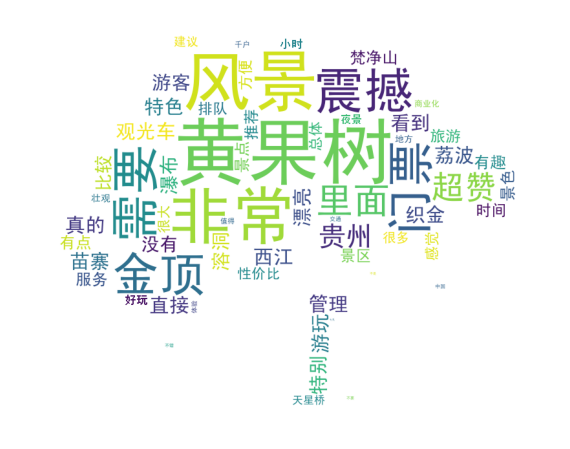

In [31]:
#五个景区向量化后的词向量矩阵和词典
#说明：final_data是向量化后的文本 即一个numpy数组 里面是每行对应的一条文本 每一行中的某个值代表对应的单词出现的频率
final_data,labels,word_table,vect,X=text_vect(all_data,0.03)



In [32]:
#总评论的词频词典  但value只是索引 不过是按词的重要性来的 及词越重要索引越大 可取消注释进行查看第一个
# word_table
sorted(word_table.items(),reverse=True)

[('黄果树', 64),
 ('风景', 63),
 ('非常', 62),
 ('震撼', 61),
 ('需要', 60),
 ('门票', 59),
 ('金顶', 58),
 ('里面', 57),
 ('超赞', 56),
 ('贵州', 55),
 ('观光车', 54),
 ('西江', 53),
 ('荔波', 52),
 ('苗寨', 51),
 ('织金', 50),
 ('管理', 49),
 ('真的', 48),
 ('看到', 47),
 ('直接', 46),
 ('特色', 45),
 ('特别', 44),
 ('瀑布', 43),
 ('漂亮', 42),
 ('溶洞', 41),
 ('游玩', 40),
 ('游客', 39),
 ('没有', 38),
 ('比较', 37),
 ('梵净山', 36),
 ('服务', 35),
 ('有趣', 34),
 ('有点', 33),
 ('景色', 32),
 ('景点', 31),
 ('景区', 30),
 ('时间', 29),
 ('旅游', 28),
 ('方便', 27),
 ('推荐', 26),
 ('排队', 25),
 ('感觉', 24),
 ('总体', 23),
 ('性价比', 22),
 ('很大', 21),
 ('很多', 20),
 ('建议', 19),
 ('小时', 18),
 ('好玩', 17),
 ('天星桥', 16),
 ('夜景', 15),
 ('壮观', 14),
 ('地方', 13),
 ('商业化', 12),
 ('千户', 11),
 ('值得', 10),
 ('体验', 9),
 ('交通', 8),
 ('中国', 7),
 ('不错', 6),
 ('不要', 5),
 ('不是', 4),
 ('七孔', 3),
 ('一次', 2),
 ('一定', 1),
 ('一去', 0)]

## 2. LDA主题建模

In [33]:
import mglearn
from sklearn.decomposition import LatentDirichletAllocation

In [34]:
# 积极情感评论
positive_view = all_data[all_data['emotion']==2]
positive_view=positive_view.reset_index()
positive_view.drop('index',axis=1,inplace=True)
#消极情感评论
negative_view = all_data[all_data['emotion']==0]
negative_view =negative_view.reset_index()
negative_view.drop('index',axis=1,inplace=True)

In [89]:
positive_view.head()

word_list  emotion
0       景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车        2
1                                             性价比        2
2                              壮观 气势磅礴 景色 不错 气候宜人        2
3                                          一般化 值得        2
4  线路 设计 成熟 有大 电梯 冤枉路 景色 不错 总体 超赞 景色 不错 有趣 好玩 性价比        2

In [35]:
negative_view.head()

word_list  emotion
0                           淡季 太坑 水帘洞 开放 景区 到处 施工 体验        0
1  白水 絮棉 不用 弓弹 自散 虹霞 似锦 何须 梭织 生成 乃是 黄果树 瀑布 真实写照 景...        0
2  黄果树 瀑布 世界 著名 瀑布 黄果树 瀑布 喀斯特地貌 侵蚀 典型 瀑布 来到 贵州 必去...        0
3                                           没到 雨季 瀑布        0
4  春暖花开 平坝 万亩 樱花 来到 黄果树 瀑布 景区 黄果树 瀑布 景区 陡坡 瀑布 黄果树...        0

In [ ]:
np.set_printoptions(suppress=True)

In [93]:
def myLda(data,senti):
    '''
    * Tfidf 生成文档词汇矩阵 LDA将其转变为以下两种矩阵
    * lda.fit_transform 返回的是document-topic matrix 文档-主题矩阵 
    * lda.components_返回的是topic-term matrix 主题--词汇矩阵

    '''
    _,_,_,vect,X=text_vect(data,0.03)
    lda = LatentDirichletAllocation(n_components=3,learning_method='online',max_iter=15,random_state=0)
    lda_topics = lda.fit_transform(X)
    
    sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
    feature_names = np.array(vect.get_feature_names())
    print("{}对应的最相关的前20个主题词汇".format(senti))

    # 每个主题的前20个关键词
    mglearn.tools.print_topics(topics=range(3), feature_names=feature_names,
                               sorting=sorting, topics_per_chunk=5, n_words=20)
    
    # 主题词汇矩阵 表示某个词语在某个主题中出现的概率
    
    a=lda.components_
    p=abs(np.sort(-a))[:,:20]/len(data)
    print(p)
    return p
    
    
    
    
    

(19111, 67)


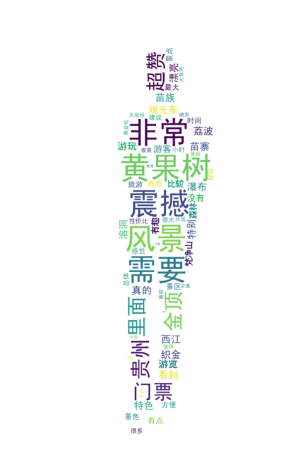

积极情感评论对应的最相关的前20个主题词汇
topic 0       topic 1       topic 2       
--------      --------      --------      
值得            景区            好玩            
不错            七孔            织金            
景色            梵净山           性价比           
非常            瀑布            总体            
风景            景点            有趣            
推荐            贵州            不错            
体验            苗寨            景色            
一去            没有            超赞            
地方            金顶            方便            
漂亮            感觉            有点            
震撼            比较            一次            
大自然           溶洞            感觉            
壮观            小时            溶洞            
真的            时间            交通            
特别            门票            体验            
喜欢            很多            门票            
很大            游玩            真的            
景区            观光车           里面            
溶洞            夜景            比较            
游玩            黄果树           很大            


[[0.08787168 0.08390923 0.0783

In [95]:
positive_p=myLda(positive_view,"积极情感评论")

(5242, 102)


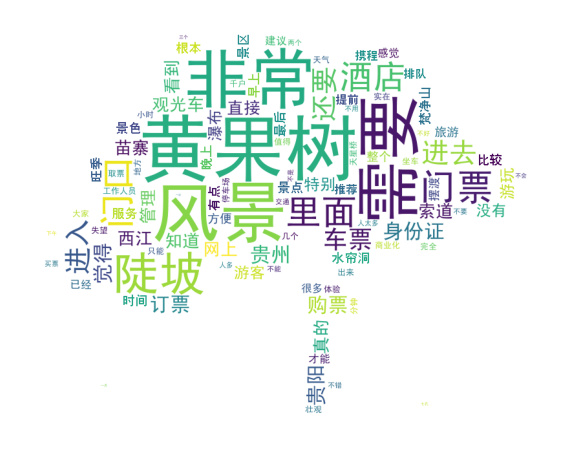

消极情感情感评论对应的最相关的前20个主题词汇
topic 0       topic 1       topic 2       
--------      --------      --------      
瀑布            地方            方便            
景区            梵净山           门票            
排队            贵州            携程            
黄果树           没有            身份证           
小时            建议            取票            
景点            不要            网上            
管理            苗寨            直接            
游客            不好            非常            
时间            体验            比较            
服务            里面            进去            
观光车           人太多           不能            
景色            景区            订票            
工作人员          值得            买票            
没有            旅游            有点            
索道            天气            提前            
水帘洞           停车场           不用            
两个            七孔            景区            
风景            商业化           购票            
游玩            一次            人多            
天星桥           真的            失望            


[[0.07736196 0.06904604 0.05

In [97]:
negative_p=myLda(negative_view,"消极情感情感评论")

In [103]:
alist1="值得 不错 景色 非常 风景 推荐 体验 一去 地方 漂亮 震撼 大自然 壮观 真的 特别 喜欢 很大 景区 溶洞 游玩".split(" ")
alist2="景区 七孔 梵净山 瀑布 景点 贵州 苗寨 没有 金顶 感觉 比较 溶洞 小时 时间 门票 很多 游玩 观光车 夜景 黄果树".split(" ")
alist3="好玩 织金 性价比 总体 有趣 不错 景色 超赞 方便 有点 一次 感觉 溶洞 交通 体验 门票 真的 里面 比较 很大".split(" ")
print(len(alist1))
print(len(alist2))
print(len(alist3))

20
20
20


In [111]:
df_positive=pd.DataFrame()
df_positive["Topic1"]=alist1
df_positive["概率1"]=positive_p[0]

df_positive["Topic2"]=alist2
df_positive["概率2"]=positive_p[1]

df_positive["Topic3"]=alist3
df_positive["概率3"]=positive_p[2]

print("积极情感倾向主题建模结果")
df_positive

积极情感倾向主题建模结果


Topic1       概率1 Topic2       概率2 Topic3       概率3
0      值得  0.087872     景区  0.070562     好玩  0.035493
1      不错  0.083909     七孔  0.049948     织金  0.035060
2      景色  0.078377    梵净山  0.048457    性价比  0.033529
3      非常  0.060484     瀑布  0.041257     总体  0.030868
4      风景  0.039346     景点  0.040894     有趣  0.029888
5      推荐  0.037659     贵州  0.031930     不错  0.028146
6      体验  0.031108     苗寨  0.029873     景色  0.028057
7      一去  0.027008     没有  0.029011     超赞  0.025948
8      地方  0.023602     金顶  0.027521     方便  0.021743
9      漂亮  0.019329     感觉  0.025812     有点  0.017260
10     震撼  0.017894     比较  0.025236     一次  0.015929
11    大自然  0.017765     溶洞  0.024607     感觉  0.000026
12     壮观  0.016015     小时  0.023002     溶洞  0.000022
13     真的  0.011422     时间  0.022338     交通  0.000022
14     特别  0.010837     门票  0.021638     体验  0.000020
15     喜欢  0.009142     很多  0.020524     门票  0.000020
16     很大  0.007310     游玩  0.019560     真的  0.000020
17     景区  0.000028    观光车  0.019277     里面  0.000020
18     溶洞  0.000021     夜景  0.019220     比较  0.000020
19     游玩  0.000020    黄果树  0.018809     很大  0.000020

In [108]:
blist1="瀑布 景区 排队 黄果树 小时 景点 管理 游客 时间 服务 观光车 景色 工作人员 没有 索道 水帘洞 两个 风景 游玩 天星桥".split(" ")
blist2="地方 梵净山 贵州 没有 建议 不要 苗寨 不好 体验 里面 人太多 景区 值得 旅游 天气 停车场 七孔 商业化 一次 真的".split(" ")
blist3="方便 门票 携程 身份证 取票 网上 直接 非常 比较 进去 不能 订票 买票 有点 提前 不用 景区 购票 人多 失望".split(" ")
print(len(blist1))
print(len(blist2))
print(len(blist3))

20
20
20


In [110]:
df_negative=pd.DataFrame()
df_negative["Topic1"]=blist1
df_negative["概率1"]=negative_p[0]

df_negative["Topic2"]=blist2
df_negative["概率2"]=negative_p[1]

df_negative["Topic3"]=blist3
df_negative["概率3"]=negative_p[2]

print("消极情感倾向主题建模结果")
df_negative

消极情感倾向主题建模结果


Topic1       概率1 Topic2       概率2 Topic3       概率3
0      瀑布  0.077362     地方  0.029954     方便  0.046561
1      景区  0.069046    梵净山  0.028501     门票  0.037628
2      排队  0.058315     贵州  0.025742     携程  0.033521
3     黄果树  0.043202     没有  0.025305    身份证  0.031174
4      小时  0.039001     建议  0.025076     取票  0.028070
5      景点  0.034517     不要  0.023077     网上  0.025348
6      管理  0.031149     苗寨  0.022915     直接  0.023937
7      游客  0.030718     不好  0.021958     非常  0.022690
8      时间  0.026647     体验  0.021772     比较  0.020433
9      服务  0.023831     里面  0.021446     进去  0.019485
10    观光车  0.019855    人太多  0.021365     不能  0.018913
11     景色  0.018646     景区  0.019327     订票  0.018740
12   工作人员  0.018032     值得  0.019209     买票  0.018388
13     没有  0.015884     旅游  0.018905     有点  0.018163
14     索道  0.014621     天气  0.018518     提前  0.016352
15    水帘洞  0.014279    停车场  0.017183     不用  0.015401
16     两个  0.014099     七孔  0.016780     景区  0.014913
17     风景  0.013101    商业化  0.015685     购票  0.014849
18     游玩  0.012981     一次  0.015477     人多  0.014296
19    天星桥  0.012637     真的  0.015419     失望  0.013595

<hr />

***

## 3. 构建循环神经网络模型
1. 采用Word2Vector技术去训练词向量
2. 采用BiLSTM去做特征学习
3. 数据为所有景区的数据 基于所有景区的数据做一个景区评论情感分析预测的系统
4. 用到上面得到的已经分好词的数据 scenic_4a,scenic_5a


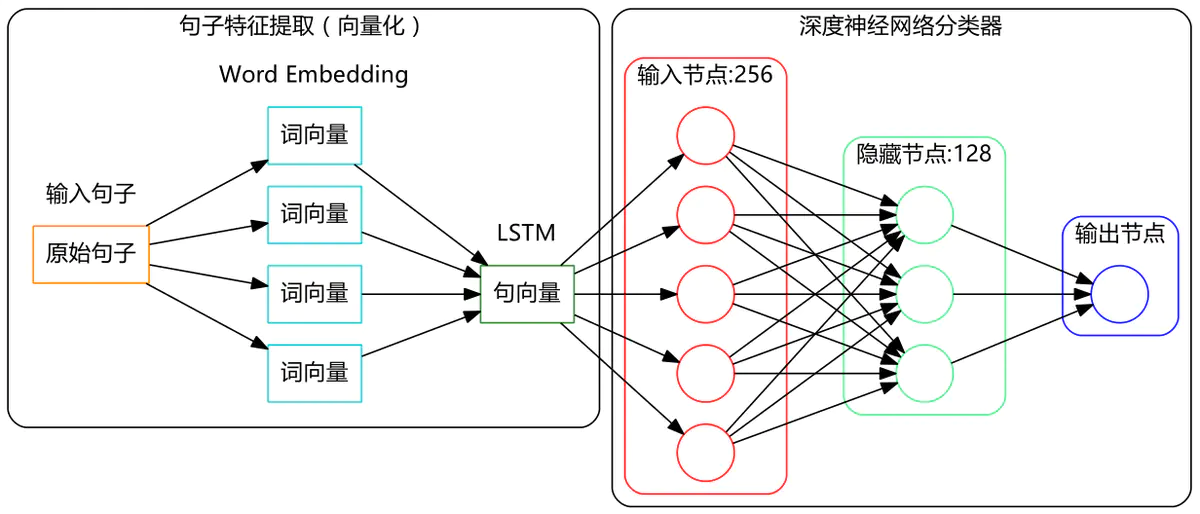

In [33]:
#导库
#word2vec考虑了文本的上下文关系 更适合用来做自然语言处理
#使用到的技术：双向长短期记忆网络 提高精度 缓解遗忘  Word2Vector技术训练词向量
import numpy as np
import pandas as pd
#word2vec生成词向量 以无监督方式学习语义知识 是深度学习方式的向量化技术 相比起tfidf 考虑了语义及上下文关系
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
from gensim import models

import jieba
import logging

from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional,LSTM,Dense,Embedding,Dropout,Activation,Softmax
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [34]:
#回顾我们之前分好词景区数据集
all_data
#0为消极 1为中立 2为积极

word_list  emotion
0      不要 以为 黄果树 门口 路过 遇到 高速 分流 前面 有个 多顿 变压器 过桥 免费 早上...        1
1              景色 不错 可惜 出口 商业化 严重 出口 左绕 右绕 全是 卖东西 半小时 乘车        2
2                                                    性价比        2
3                               淡季 太坑 水帘洞 开放 景区 到处 施工 体验        0
4                                               非常 非常 非常        1
...                                                  ...      ...
27701                                           捆绑 消费 不好        0
27702                                  此山 值得 一登 五岳 值得 推荐        2
27703        本次 旅游 遇到 大风 天气 排队 五个 小时 景区 工作人员 服务 意识 景色 不错        1
27704         景色 非常 优美 旺季 旅游 人太多 上山 排队 四个 小时 下山 三个 小时 够呛        2
27705                           觉得 梵净山 只能 航拍 路线 觉得 设计 问题        2

[27544 rows x 2 columns]

In [35]:
#已经向量化的景区评论
final_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.84357283],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.30579874, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:

print(all_data['emotion'].value_counts())
print("="*20)
print(all_data['emotion'].value_counts(normalize=True))


2    19111
0     5242
1     3191
Name: emotion, dtype: int64
2    0.693835
0    0.190314
1    0.115851
Name: emotion, dtype: float64


### 2.1 使用word2vec技术训练词向量

In [37]:
#把我们需要的分好词的文本和情感标签分出来 并保存为列表 方便我们后面训练词向量模型
all_data2=list(all_data['word_list'])
labels2=list(all_data['emotion'])


In [38]:
#定义一个词向量训练函数这一步将一个词映射成一个100维的向量，并且考虑到了上下文的语义。
#这里直接将上一部得到的句子列表传给train_word2vec函数就可以了，同时需要定义一个词向量文件保存路径。
#模型保存后，以后使用就不需要再次训练，直接加载保存好的模型就可以啦。
#输出某个景区分好词后的数据
def train_word2vec(scenic_data,save_path):
    sentences_seg=[]
    sen_list=list(scenic_data['word_list'])
    for i in sen_list:
        sentences_seg.append(i.split())
    #去除停用词
    print("开始训练词向量")
    word_model=Word2Vec(sentences_seg,
                        vector_size=100,#词向量维度
                        min_count=5, #词频阈值
                        window=5)   #窗口大小
    word_model.save(save_path)
    print("训练完毕，并保存训练好的词向量模型")
    return word_model

    

In [39]:
#训练并保存4a景区的词向量模型 

word_model=train_word2vec(all_data,'./mymodels/word2vec.model')

开始训练词向量
训练完毕，并保存训练好的词向量模型


***

### 2.2 数据预处理 定义一些处理数据和将数据准换成神经网络模型需要的张量数据形式
1. generate_id2wec(word2vec_model) 输入上一步得到的词向量模型 返回词典(词+索引的字典) 词向量矩阵


2. text_to_array(w2index,senlist) 输入词典 和要转换为索引的文本 得到一个索引组成的numpy数组 每个索引代表一个词


3. prepare_data(w2id,sentences,labels,max_len=200) 输入词典 分好词的文本数据 对应的标签 序列最大长度 得到能直接喂养给神经网络模型的数据 x,y训练集 x,y验证集
 

In [40]:
#定义一些数据处理和变换方法
def generate_id2wec(word2vec_model):
    gensim_dict=Dictionary()
    gensim_dict.doc2bow(word2vec_model.wv.key_to_index,allow_update=True) #得到的gensim_dict key为索引 value为单词
    
    w2id={v:k+1 for k,v in gensim_dict.items()} #词典 key为单词 value为索引
    w2vec={word: word2vec_model.wv[word] for word in w2id.keys()}   #词语的词向量
    n_vocabs=len(w2id)+1
    embedding_weights=np.zeros((n_vocabs,100))
    for w,index in w2id.items():  #从索引为1的词语开始，用词向量填充索引矩阵
        embedding_weights[index,:]=w2vec[w]
    return w2id,embedding_weights

#文本转为数字索引
def text_to_array(w2index,senlist): 
    sentences_array=[]
    #将输入的文本的转为对应的单词索引
    for sen in senlist:
        new_sen=[w2index.get(word,0) for word in sen]
        sentences_array.append(new_sen)
    return np.array(sentences_array)

def prepare_data(w2id,sentences,labels,max_len=200):
    X_train,X_val,y_train,y_val=train_test_split(sentences,labels,test_size=0.2,random_state=99)
    X_train=text_to_array(w2id,X_train)
    X_val=text_to_array(w2id,X_val)
    #将序列填充到相同的长度 keras只能接受长度相同的序列输入 maxlen 为序列最大的长度 大于它的截断 小于它的填0
    X_train=pad_sequences(X_train,maxlen=max_len)
    X_val=pad_sequences(X_val,maxlen=max_len)
    return np.array(X_train),np_utils.to_categorical(y_train),np.array(X_val),np_utils.to_categorical(y_val)

In [41]:
#输入训练好的景区的词向量模型 
#得到景区的词典w2id  和词向量矩阵embedding_weights
w2id_,embedding_weights_=generate_id2wec(word_model)

In [42]:
#查看词典
w2id_

{'---': 1,
 '----': 2,
 '-----': 3,
 '------': 4,
 '-.': 5,
 '.%': 6,
 '.&': 7,
 '.-': 8,
 '.-.': 9,
 '..': 10,
 '....': 11,
 '.....': 12,
 '_____________________': 13,
 '一上午': 14,
 '一下': 15,
 '一下子': 16,
 '一不小心': 17,
 '一丝': 18,
 '一两': 19,
 '一两个': 20,
 '一两天': 21,
 '一个个': 22,
 '一个半': 23,
 '一个多': 24,
 '一个月': 25,
 '一个样': 26,
 '一个点': 27,
 '一串': 28,
 '一举': 29,
 '一二': 30,
 '一人': 31,
 '一件': 32,
 '一份': 33,
 '一会': 34,
 '一会儿': 35,
 '一位': 36,
 '一体': 37,
 '一侧': 38,
 '一個': 39,
 '一倍': 40,
 '一元': 41,
 '一共': 42,
 '一出': 43,
 '一分': 44,
 '一分为二': 45,
 '一分钟': 46,
 '一切都是': 47,
 '一到': 48,
 '一刻': 49,
 '一副': 50,
 '一千': 51,
 '一千块': 52,
 '一千多': 53,
 '一半': 54,
 '一去': 55,
 '一双': 56,
 '一口': 57,
 '一口气': 58,
 '一句': 59,
 '一只': 60,
 '一台': 61,
 '一号': 62,
 '一同': 63,
 '一名': 64,
 '一周': 65,
 '一味': 66,
 '一回': 67,
 '一团': 68,
 '一团糟': 69,
 '一圈': 70,
 '一地': 71,
 '一场': 72,
 '一坐': 73,
 '一块': 74,
 '一块块': 75,
 '一堆': 76,
 '一塌糊涂': 77,
 '一声': 78,
 '一壶': 79,
 '一处': 80,
 '一处处': 81,
 '一夜': 82,
 '一大': 83,
 '一大半': 84,
 '一大堆': 85,
 '一大早': 86,

In [43]:
#查看词向量矩阵
embedding_weights_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.35899860e-02,  1.11814871e-01,  1.11558419e-02, ...,
        -1.83742177e-02,  4.55550700e-02, -3.51224304e-03],
       [-1.38391629e-01,  2.30043724e-01,  1.89615879e-02, ...,
         5.78764342e-02, -2.52201930e-02,  6.71696663e-02],
       ...,
       [-2.32957587e-01,  5.20972490e-01,  5.79697601e-02, ...,
        -3.43722329e-02,  1.23167068e-01, -1.95406731e-02],
       [-4.45901304e-02,  3.14358138e-02, -1.12094381e-03, ...,
         1.07759321e-02,  6.40204223e-03, -3.46827991e-02],
       [-1.33792579e+00,  7.40452409e-01,  8.79139662e-01, ...,
        -7.06203878e-02, -4.67044026e-01,  1.43062798e-02]])

***


In [44]:
#将景区的数据处理成能直接喂养给模型的数据 输入词典 文本数据 情感标签 序列最大长度 
# 得到划分和处理后的训练集和测试集
x_train,y_train,x_val,y_val=prepare_data(w2id_,all_data2,labels2,200)


In [45]:
x_train.shape,x_val.shape,x_train.shape,x_val.shape

((22035, 200), (5509, 200), (22035, 200), (5509, 200))

In [46]:
y_train.shape,y_train.shape

((22035, 3), (22035, 3))

In [47]:
#使用class_weight解决情绪占比不平衡 严重影响神经网络模型性能的问题 
#在给定权重之前 模型训练集准确率最高仅为0.73 验证集仅为0.71
from sklearn.utils import class_weight
weights_=class_weight.compute_class_weight('balanced',np.unique(all_data['emotion']),all_data['emotion'])
print("景区的各情绪权重:")
class_weights_=dict(enumerate(weights_))
print(class_weights_)



景区的各情绪权重:
{0: 1.7514943405824748, 1: 2.877258957484592, 2: 0.4804213977988244}


### 2.3 构建模型 
1. 定义了一个Sentiment类，封装了模型的构建、训练和预测方法


2. build_model(self) 构造模型


3. mytrain(self,X_train,y_train,X_test,y_test,n_epoch=6) 训练并保存模型 不指定n_epochs 默认为迭代6次


4. mypredict(self,model_path,new_sen) 模型预测方法 输入一条文本能够预测该条文本的情感



In [48]:
class Sentiment:
    def __init__(self,w2id,embedding_weights,Embedding_dim,max_len,labels_category):
        self.Embedding_dim=Embedding_dim
        self.embedding_weights=embedding_weights
        self.vocab=w2id
        self.labels_category=labels_category
        self.maxlen=max_len
        self.model=self.build_model()
        
    def build_model(self):
        model=Sequential()
        model.add(Embedding(output_dim=self.Embedding_dim,
                           input_dim=len(self.vocab)+1,
                           weights=[self.embedding_weights],
                           input_length=self.maxlen))
        model.add(Bidirectional(LSTM(32)))
        #Dropout层 降低过拟合
        model.add(Dropout(0.5))
        #输出层 三种值 消极 中立 积极
        model.add(Dense(self.labels_category))
        model.add(Activation('softmax'))
        
        #编译模型
        model.compile(optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'],
                    )
        model.summary()
        return model
    
    def mytrain(self,X_train,y_train,X_test,y_test,n_epoch=6):
        
        weights=class_weights_
     
        self.model.fit(X_train,
                       y_train,
                       batch_size=32,
                       epochs=n_epoch,
                       validation_data=(X_test,y_test),
                       class_weight=weights)
        #保存训练好的模型
        self.model.save('./mymodels/sentiment_nerve_model.h5')
        
    def mypredict(self,model_path,new_sen):
        model=self.model
        model.load_weights(model_path)
        new_sen_list=jieba.lcut(new_sen)
        sen2id=[self.vocab.get(word,0) for word in new_sen_list]
        sen_input=pad_sequences([sen2id],maxlen=self.maxlen)
        res=model.predict(sen_input)[0]  #得到的是二维列表 索引一下
#         print(res)
        return np.argmax(res)
        

### 2.4 训练景区所有的数据 并保存训练好的模型

In [49]:
#实例化一个对象 传入{单词：索引}字典w2id_, 传入词向量矩阵embedding_weights_ 词嵌入维度100 序列最大长度200 预测种类3种
senti1=Sentiment(w2id_,embedding_weights_,100,200,3)
#模型训练  1个epoch 可以再增加
senti1.mytrain(x_train,y_train,x_val,y_val,1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          962300    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 996,543
Trainable params: 996,543
Non-trainable params: 0
_________________________________________________________________
689/689 [==============================] - 88s 122ms/step - loss: 1.0946 - accuracy: 0.3792 - val_loss: 1.0880 - val

In [50]:
#4a景区评论情感预测
label_dic={0:'消极的',1:'中立的',2:'积极的'}
sen_new=input()
pre=senti1.mypredict("./mymodels/sentiment_nerve_model.h5",sen_new)
print("{}的情感是:\n{}".format(sen_new,label_dic.get(pre)))

景色 非常 优美 旺季 旅游 人太多 上山 排队 四个 小时 下山 三个 小时 够呛
景色 非常 优美 旺季 旅游 人太多 上山 排队 四个 小时 下山 三个 小时 够呛的情感是:
积极的


****

## 3. 总结
1. 在这个过程中需要安装的库
    1. 安装keras 需要先安装tensorflow 使用keras进行深度学习
    2. 安装wordcloud 绘制词云图
    3. 安装gensim 使用word2vec训练词向量模型
2. 使用了wordcloud绘制词云图 首先分别绘制了每个景区的基于文本的词云图 然后绘制了景区的基于词频的词云图
3. 使用word2vec对文本进行向量化 
4. 定义了一个Sentiment类 里面定义了循环神经网络模型构建、训练和预测的方法
5. 针对情感分布不平衡 定义了focal_loss1函数作为损失函数 使用权重来平衡这种不平衡带来的影响
6. 最后可以使用predict方法预测评论的情感